In [1]:
import pandas as pd
# loads X train dataset (features of each instance)
x_train = pd.read_csv('CompleteDataSet/x_train_all.csv')
# load Y train dataset (classes of each instance)
y_train=pd.read_csv('CompleteDataSet/y_train_all.csv')

x_train.shape

(9690, 2304)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import accuracy_score




In [124]:
def silhouetteScore(data, clustersdata):
    silhouette_avg = silhouette_score(data, clustersdata)
    print("Silhouette Score:", silhouette_avg)
    return silhouette_avg

### Create Diff kinds of dataframe


##### PCA

In [4]:
n_components = 1500  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x_train)

pca1000 = PCA(n_components=1000)
X_pca1000 = pca1000.fit_transform(x_train)

pca2000 = PCA(n_components=2000)
X_pca2000 = pca2000.fit_transform(x_train)

def PCAOnData(data,components):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(data)
    df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    return df_pca

##### Pre-Processed

In [5]:
processed_df = pd.read_csv('processed_df.csv')

##### Infra-Red


In [6]:
def grayscale_to_infrared(grayscale_image):
    row = np.array(grayscale_image, dtype=np.uint8)
    color_map = plt.get_cmap('hot')
    normalized_image = row / 255.0
    infrared_image = (color_map(normalized_image)[:, :, 0] * 255).astype(np.uint8)
    return infrared_image.flatten()

In [7]:
infrared_original = []

for i, idx in enumerate(x_train.index):
    original_image = x_train.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_org = pd.DataFrame(infrared_original)
infrared_df_org.shape

(9690, 2304)

In [8]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in x_train.columns]
infrared_copy = x_train.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_no_outliers = infrared_copy.drop(outlier_indices)
infra_no_outliers.to_csv('x_train_no_outliers.csv',index=False)

outlier_indices_df = pd.DataFrame({'outlier_index': outlier_indices})

outlier_indices_df.to_csv('outlier_indices.csv', index=False)

In [9]:
y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train_no_outliers = y_train.drop(outlier_indices)

In [10]:
mean=infra_no_outliers.mean()
std=infra_no_outliers.std()
infra_norm=(infra_no_outliers-mean)/std

In [11]:
mean=x_train.mean()
std=x_train.std()
x_norm=(x_train-mean)/std

In [12]:
infrared_original = []

for i, idx in enumerate(x_norm.index):
    original_image = x_norm.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_norm = pd.DataFrame(infrared_original)
infrared_df_norm.shape

(9690, 2304)

In [13]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in infrared_df_norm.columns]
infrared_copy = infrared_df_norm.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_norm_no_outliers = infrared_copy.drop(outlier_indices)

In [14]:
import cv2
def apply_gaussian_blur(row, kernel_size=(5, 5), sigma=0):
    row = np.array(row, dtype=np.uint8)
    row = cv2.GaussianBlur(row, kernel_size, sigma)
    return row

def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

In [15]:
infrared_prep = []

for index, row in infra_norm_no_outliers.iterrows():
    image_data = row.values
    gaussian_image = apply_gaussian_blur(image_data)
    equalized_image = apply_clahe(gaussian_image)
    infrared_prep.append(equalized_image.flatten())

prepped_infrared_df = pd.DataFrame(infrared_prep)
prepped_infrared_df.shape

(9593, 2304)

In [16]:
image_df = prepped_infrared_df.copy()

In [17]:
import cv2
import pandas as pd
import numpy as np

# Assuming 'image_df' is your DataFrame with each row as an image

# Create a list to store the Fourier Transformed images
fourier_transformed_images = []

# Iterate through each row (image) in the DataFrame
for index, row in image_df.iterrows():
    # Convert the row (image) to a NumPy array
    image = row.values.reshape(48, 48)

    # Apply DFT to the image
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero frequency components to the center
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1])

    # Flatten the magnitude spectrum to 1D
    flattened_magnitude_spectrum = magnitude_spectrum.flatten()

    # Append the flattened magnitude spectrum to the list
    fourier_transformed_images.append(flattened_magnitude_spectrum)

# Create a new DataFrame from the Fourier Transformed images
fourier_df = pd.DataFrame(fourier_transformed_images)

# The 'fourier_df' DataFrame now contains the magnitude spectra of the images


In [18]:
fourier_df.shape

(9593, 2304)

In [19]:
image_df = fourier_df.copy()

In [20]:
import numpy as np
import cv2  # Make sure you have OpenCV installed

# Define a function to emphasize lower frequencies using DCT
def emphasize_lower_frequencies(image, keep_ratio=0.1):
    # Apply DCT
    dct = cv2.dct(np.float32(image))

    # Determine the threshold to retain keep_ratio of the coefficients
    sorted_dct = np.sort(np.abs(dct), axis=None)
    threshold = sorted_dct[int(keep_ratio * sorted_dct.size)]

    # Zero out high-frequency coefficients
    dct[np.abs(dct) < threshold] = 0

    # Apply inverse DCT to get the filtered image
    filtered_image = cv2.idct(dct)
    
    return filtered_image


In [21]:
image_df = prepped_infrared_df.copy()

filtered_images = []

for index, row in image_df.iterrows():
    image_data = row.values
    filtered_image = emphasize_lower_frequencies(image_data, keep_ratio=0.1)
    filtered_images.append(equalized_image.flatten())

filtered_df = pd.DataFrame(filtered_images)
filtered_df.shape

(9593, 2304)

In [22]:
image_df = prepped_infrared_df.copy()

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data_normalized = scaler.fit_transform(image_df)

In [24]:
import cv2

def apply_median_filter(image, kernel_size=37):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_blur_cv(image, kernel_size=(15, 15)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_bilateral_filter(image, diameter=25, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

In [25]:
image_df = prepped_infrared_df.copy()
infrared_prep2 = []

for index, row in image_df.iterrows():
    image_data = row.values
    median_image = apply_median_filter(image_data)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    median_image = apply_median_filter(gaussian_image)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    infrared_prep2.append(gaussian_image.flatten())

prepped_infrared_df2 = pd.DataFrame(infrared_prep2)
prepped_infrared_df2.shape

(9593, 2304)

In [26]:
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [27]:
pca_3 = PCAOnData(prepped_infrared_df2,3)

### Visualise


In [96]:
def TSNEplots(data,clusterlabels,title):
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)

    dataTSNE = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

### Create Clustering Algos


##### Agglomerative Clustering

In [29]:
def aggfunc(data, k):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    clusters = agg_clustering.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [30]:
agg_10_clusters_labels = aggfunc(x_train,10)

In [31]:
silhouetteScore(x_train,agg_10_clusters_labels)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


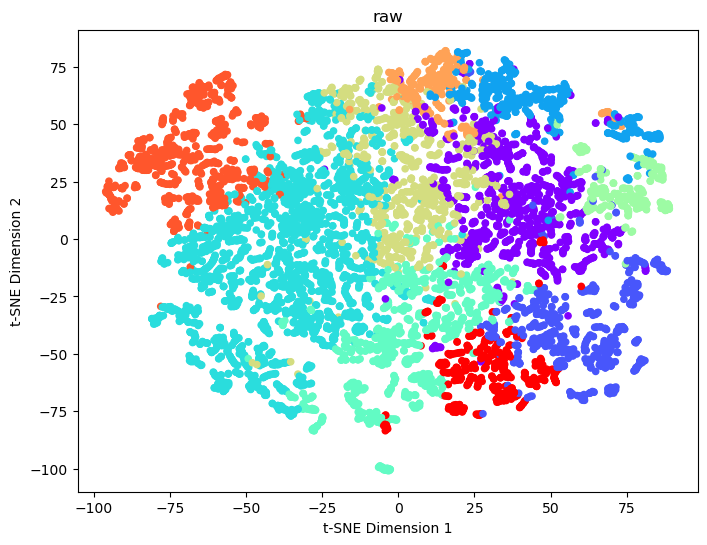

In [97]:
TSNEplots(x_train.to_numpy(),agg_10_clusters_labels,"raw")

In [146]:
silhouetteScoreAllRaw = [] 
for i in range(2, 12): 
    raw_labels_pred = aggfunc(x_train,i)
    silhouetteScoreAllRaw.append(silhouetteScore(x_train,raw_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3532791090619684


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1879831451772538


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.19888231502242126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.20393837995988515


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.21153913098707894


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1983724831499671


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2006722206263219


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.0941067338452834


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08785947340116355


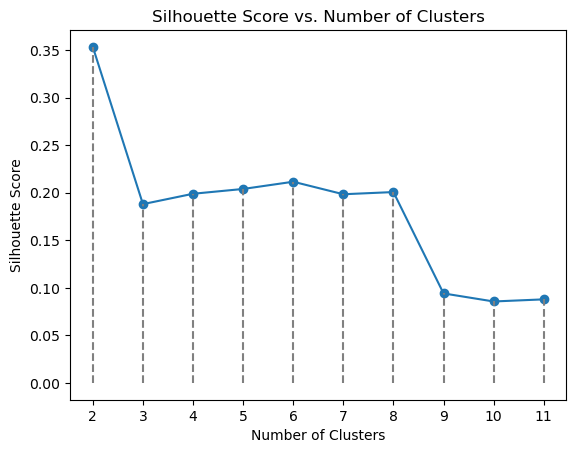

In [147]:
cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllRaw, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllRaw[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [33]:
agg_10_clusters_labels_infra = aggfunc(infrared_df_org,10)

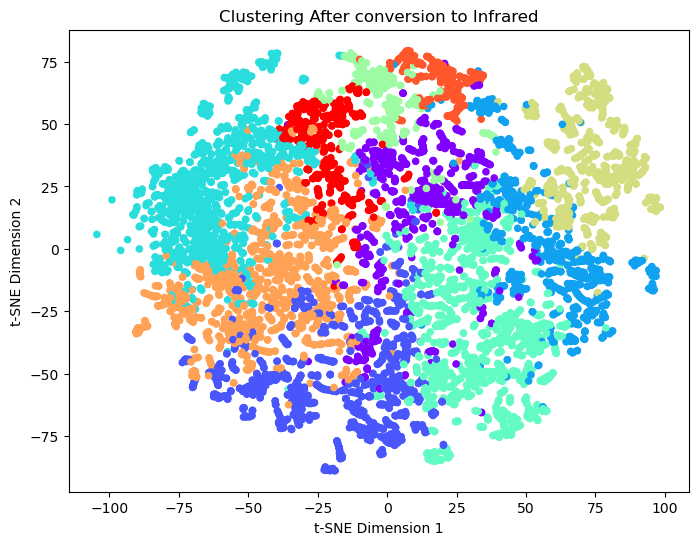

In [99]:
TSNEplots(infrared_df_org,agg_10_clusters_labels_infra,"Clustering After conversion to Infrared")

In [35]:
silhouetteScore(infrared_df_org,agg_10_clusters_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.10424093019253086


In [36]:
clusters_infra_no_outliers = aggfunc(infra_no_outliers, 10)
silhouetteScore(infra_no_outliers,clusters_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


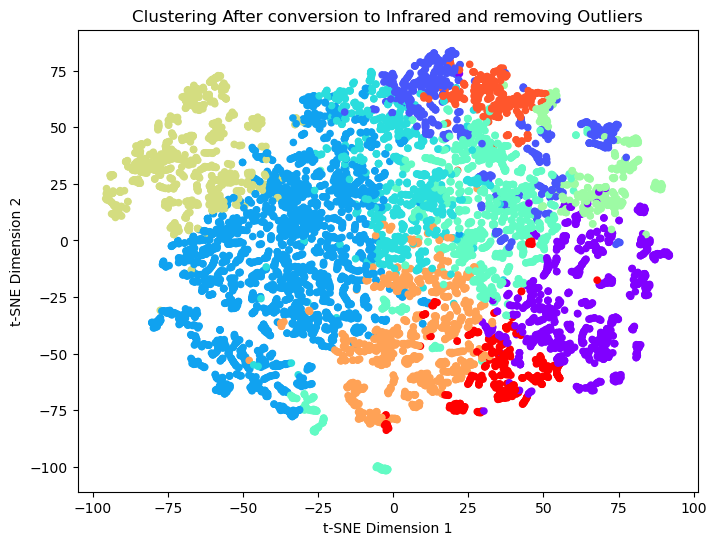

In [100]:
TSNEplots(infra_no_outliers,clusters_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [101]:
clusters_infra_norm = aggfunc(infra_norm, 10)
silhouetteScore(infra_norm,clusters_infra_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08682438504803372


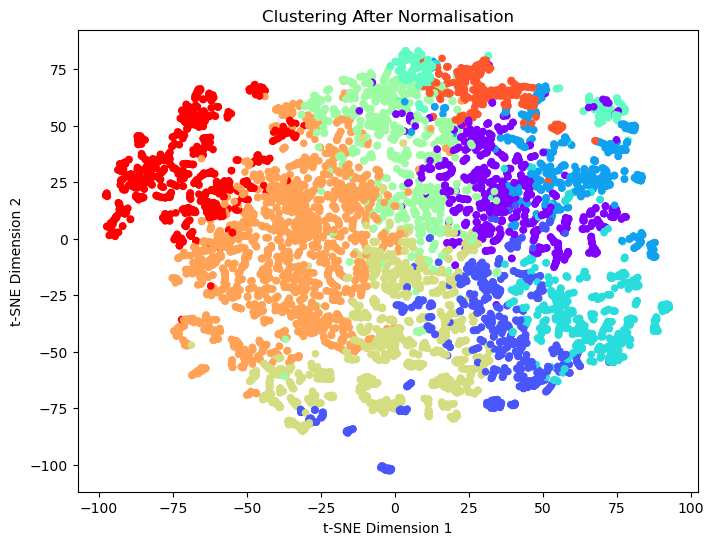

In [102]:
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After Normalisation")

In [103]:
clusters_infrared_df_norm = aggfunc(infrared_df_norm, 10)
silhouetteScore(infrared_df_norm,clusters_infrared_df_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46254749032402126


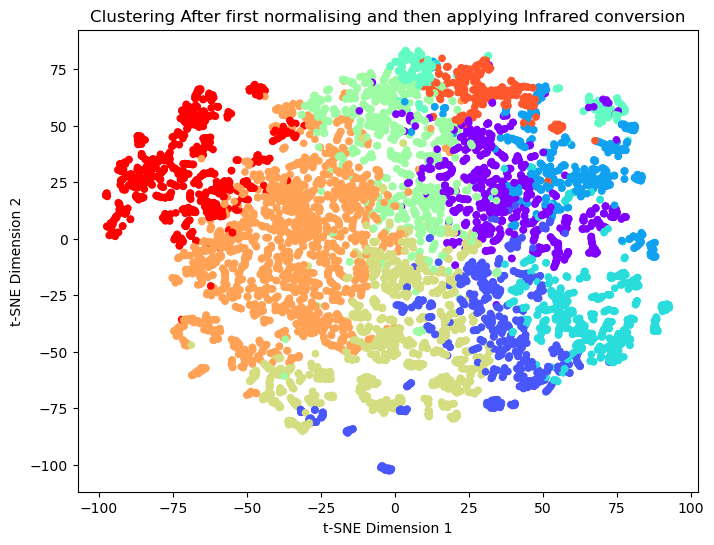

In [104]:
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After first normalising and then applying Infrared conversion")

In [105]:
clusters_infra_norm_no_outliers = aggfunc(infra_norm_no_outliers, 10)
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


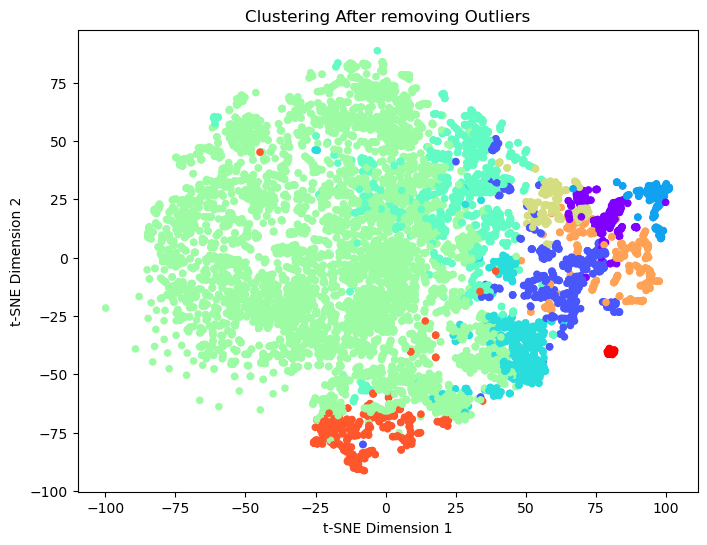

In [106]:
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers,"Clustering After removing Outliers")

In [128]:
silhouetteScoreAll = [] 
for i in range(2, 15): 
    
    clustersLabels = aggfunc(infra_norm_no_outliers,i)
    silhouetteScoreAll.append(silhouetteScore(infra_norm_no_outliers,clustersLabels))



KeyboardInterrupt: 

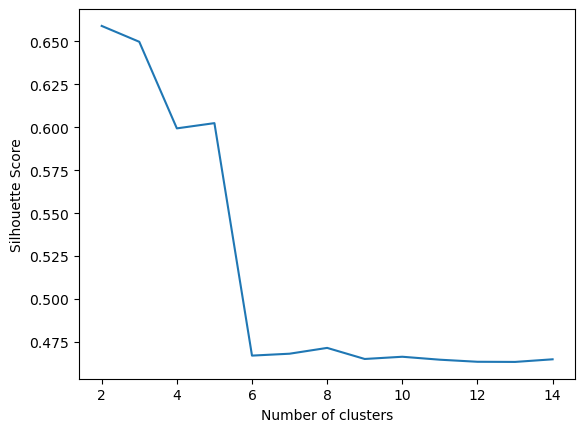

In [127]:
plt.plot(range(2, 15), silhouetteScoreAll)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
plt.show()

In [108]:
clusters_infra_norm_no_outliers_2 = aggfunc(infra_norm_no_outliers, 2)
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


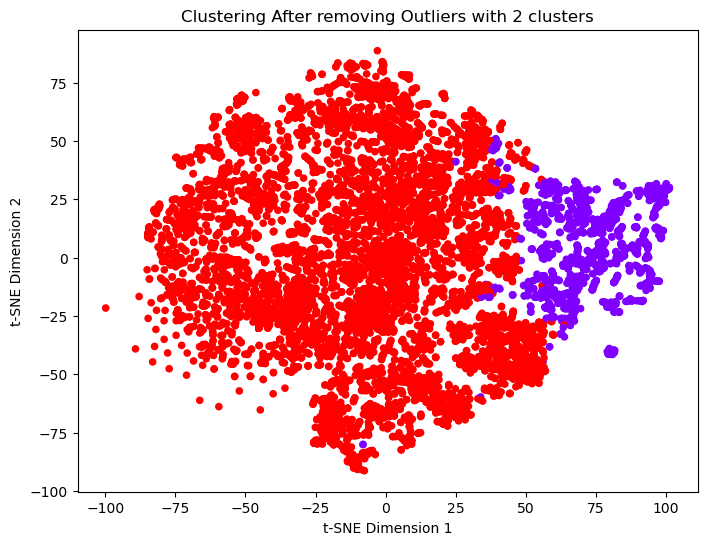

In [109]:
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [110]:
clusters_preprocessed = aggfunc(prepped_infrared_df, 10)
silhouetteScore(prepped_infrared_df,clusters_preprocessed)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.44571711187269836


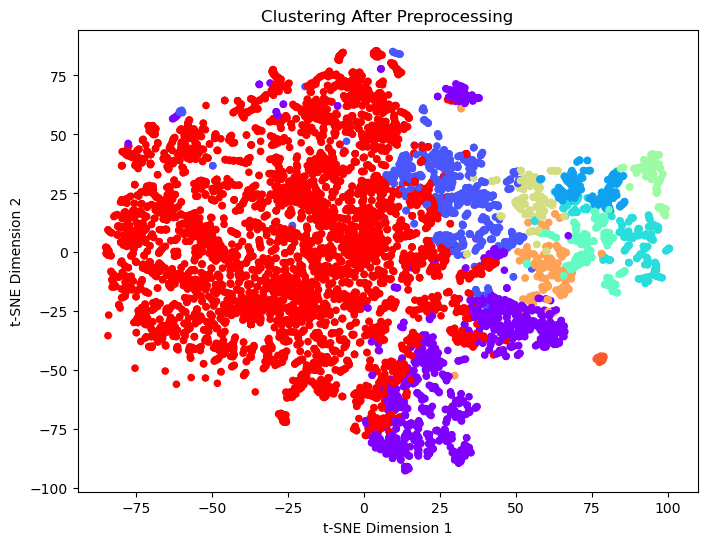

In [111]:
TSNEplots(prepped_infrared_df,clusters_preprocessed,"Clustering After Preprocessing")

In [112]:
clusters_preprocessed_2 = aggfunc(prepped_infrared_df, 2)
silhouetteScore(prepped_infrared_df,clusters_preprocessed_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


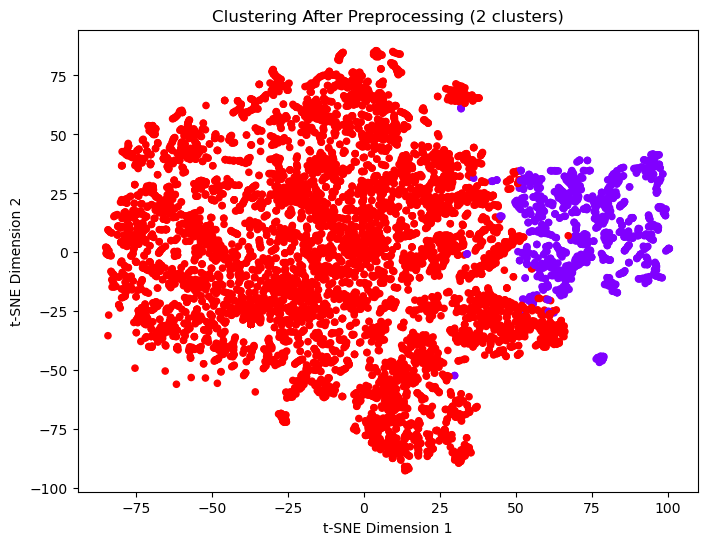

In [113]:
TSNEplots(prepped_infrared_df,clusters_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [44]:
df_pca_50 = PCAOnData(prepped_infrared_df, 50)
clusters_pca50 = aggfunc(df_pca_50, 10)
silhouetteScore(df_pca_50, clusters_pca50)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.48610955106777737


In [46]:
clusters = aggfunc(prepped_infrared_df2, 10)
silhouetteScore(prepped_infrared_df2, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.786266646588159


In [47]:
clusters = aggfunc(prepped_infrared_df, 2)
silhouetteScore(prepped_infrared_df, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


In [48]:
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [49]:
clusters = aggfunc(pca_50, 10)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7872079356565395


In [50]:
clusters = aggfunc(pca_50, 5)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7992193949794117


In [51]:
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [52]:
clusters = aggfunc(pca_50, 2)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8664894784735309


In [132]:
iso_df = prepped_infrared_df2.copy()

In [133]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
iso_data = isomap.fit_transform(iso_df)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\mujta\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [139]:
def lp_intensify(arr, lower_percentile, upper_percentile):
    lower_limit = np.percentile(arr, lower_percentile)
    upper_limit = np.percentile(arr, upper_percentile)
    
    arr[arr < lower_limit] = 0
    arr[arr > upper_limit] = 255
    
    return arr

data = iso_data.copy()
lower_frequency_data = lp_intensify(data, 87, 90)

C:\Users\mujta\AppData\Local\Temp\ipykernel_9672\1976246888.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)


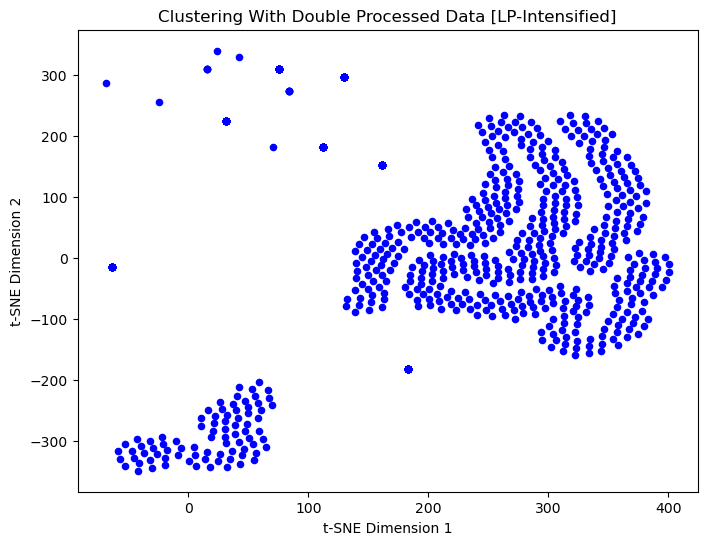

In [140]:
TSNEplots(lower_frequency_data.copy(),'b',"Clustering With Double Processed Data [LP-Intensified]")

In [141]:
silhouetteScoreAll = [] 
lfd = lower_frequency_data.copy()
for i in range(2, 15): 
    
    clustersLabels = aggfunc(lfd,i)
    silhouetteScoreAll.append(silhouetteScore(lfd,clustersLabels))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8219683117859206


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9559656747743789


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9903732291634493


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9708006803981317


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9726766616035946


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9696134690118321


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9725839252383244


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9724330022560203


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.972801141885017


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9713207248331386


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9712409332420776


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9720436414574629


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9720435678515499


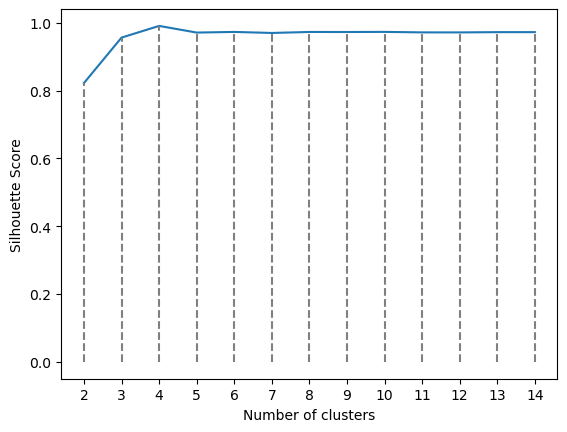

In [144]:
plt.plot(range(2, 15), silhouetteScoreAll)
plt.xticks(range(2, 15))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
clusterRange = range(2, 15)
for i in clusterRange:
    index = i - 2
    plt.plot([clusterRange[index], clusterRange[index]], [0, silhouetteScoreAll[index]], linestyle='--', color='gray')

plt.show()

In [134]:
testing_df = iso_data.copy()

y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train = y_train.drop(outlier_indices)
y_train = np.asarray(y_train)

cluster_labels = aggfunc(testing_df,10)


In [136]:
data = []
labels = []

for cluster_label in np.unique(cluster_labels):
    cluster_mask = (cluster_labels == cluster_label)
    X_cluster = testing_df[cluster_mask]
    y_cluster = y_train[cluster_mask].flatten()
    majority_class = np.bincount(y_cluster).argmax()

    for unique_class in y_cluster:
        class_size = np.sum(y_cluster == unique_class)

    data.append(X_cluster)
    labels.append(y_cluster)

data = np.concatenate(data, axis=0)
labels = np.concatenate(labels)


In [137]:
accuracy = accuracy_score(y_train, labels)
accuracy

0.6569373501511518

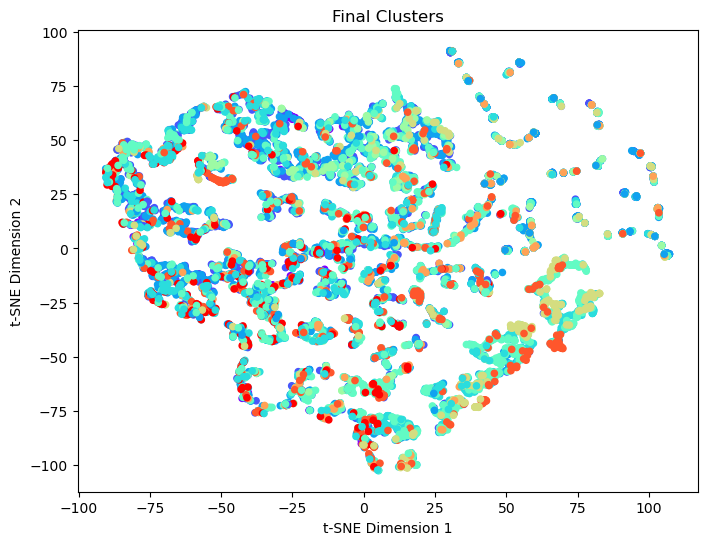

In [138]:
TSNEplots(testing_df,labels,"Final Clusters")

In [145]:
silhouetteScoreAll1 = [0.658983680565739,0.6497470524049589,0.5993403350000828,0.602393660684713,0.4670504658963724,0.46815855705203424,0.47154068178230957,0.465090706813612,0.46638652388869367,0.4646668602861849,0.46346324923462934,0.4633759228662821,0.46489932057515354]
silhouetteScoreAll2 = silhouetteScoreAll

In [167]:
raw_scores = silhouetteScoreAllRaw[::2]
processed_scores = silhouetteScoreAll[::2]
silhouette_bf = [raw_scores,processed_scores[0:5]]


In [157]:
silhouette_bf[1].__len__()

10

# Comparision

In [168]:
x_axis = ["Raw", "After Pre-processing"]
y_axis = ["2 Clusters", "4 Clusters", "6 Clusters", "8 Clusters", "10 Clusters"] 
pd.DataFrame(silhouette_bf, x_axis, y_axis)

,2 Clusters,4 Clusters,6 Clusters,8 Clusters,10 Clusters
Raw,0.353279,0.198882,0.211539,0.200672,0.085637
After Pre-processing,0.821968,0.990373,0.972677,0.972584,0.972801


# Spectral Clustering

In [169]:
from sklearn.cluster import SpectralClustering


In [170]:
def spectralfunc(data,n_clusters):
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf',random_state=19)
    clusters = spectral_clustering.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [171]:
spectral_labels_raw = spectralfunc(x_train,10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [172]:
silhouetteScore(x_train,spectral_labels_raw)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: -0.4321895926381354


-0.4321895926381354

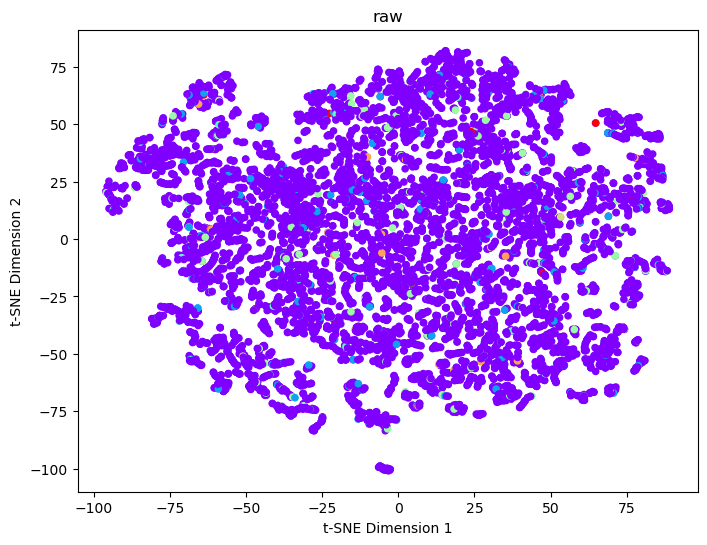

In [173]:
TSNEplots(x_train.to_numpy(),spectral_labels_raw,"raw")

In [174]:
spectral_labels_infra = spectralfunc(infrared_df_org,10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [175]:
silhouetteScore(infrared_df_org,spectral_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: -0.033375329777027556


-0.033375329777027556

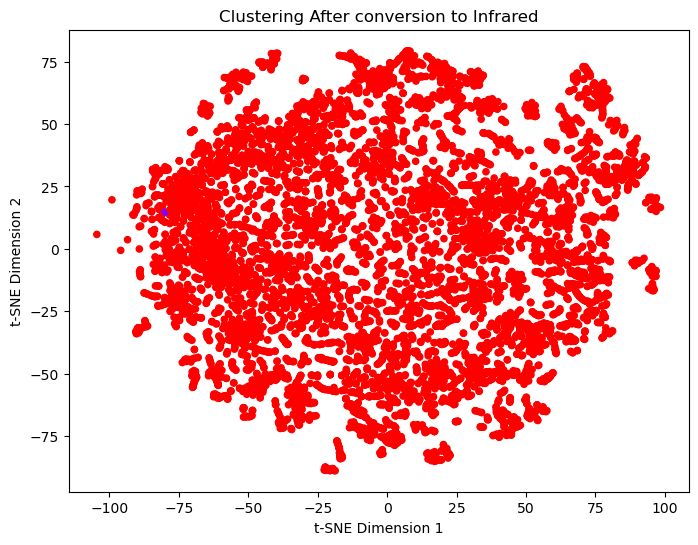

In [176]:
TSNEplots(infrared_df_org,spectral_labels_infra,"Clustering After conversion to Infrared")

In [177]:
spectral_labels_infra_no_outliers = spectralfunc(infra_no_outliers, 10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [178]:
silhouetteScore(infra_no_outliers,spectral_labels_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: -0.19506292829944086


-0.19506292829944086

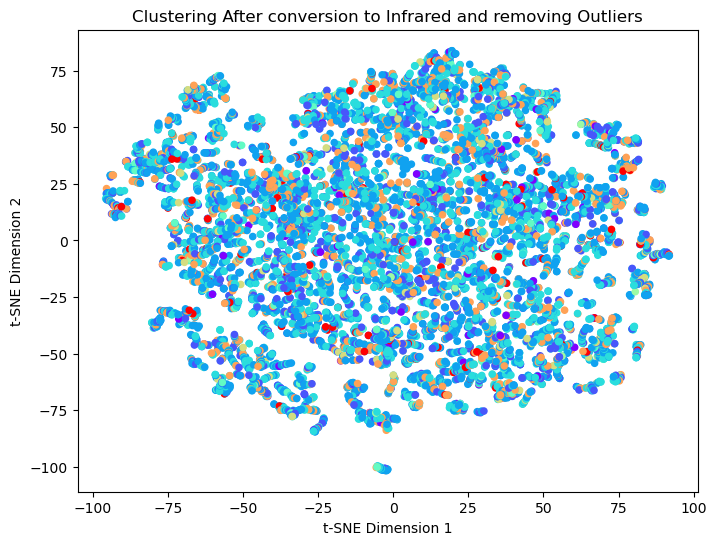

In [179]:
TSNEplots(infra_no_outliers,spectral_labels_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [206]:
spectral_labels_infrared_df_norm = spectralfunc(infrared_df_norm, 10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
silhouetteScore(infrared_df_norm,spectral_labels_infrared_df_norm)

In [ ]:
TSNEplots(infrared_df_norm,spectral_labels_infrared_df_norm,"Clustering After Normalisation")

In [207]:
spectral_labels_infrared_norm_no_outliers = spectralfunc(infra_norm_no_outliers, 10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
silhouetteScore(infra_norm_no_outliers,spectral_labels_infrared_norm_no_outliers)

In [ ]:
TSNEplots(infra_norm_no_outliers,spectral_labels_infrared_norm_no_outliers,"Clustering After removing Outliers")

In [ ]:
spectral_infra_norm_no_outliers_2 = spectralfunc(infra_norm_no_outliers, 2)


In [ ]:
silhouetteScore(infra_norm_no_outliers,spectral_infra_norm_no_outliers_2)

In [ ]:
TSNEplots(infra_norm_no_outliers,spectral_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [ ]:
spectral_preprocessed = spectralfunc(prepped_infrared_df, 10)


In [ ]:
silhouetteScore(prepped_infrared_df,spectral_preprocessed)

In [ ]:
TSNEplots(prepped_infrared_df,spectral_preprocessed,"Clustering After Preprocessing")

In [ ]:
spectral_preprocessed_2 = spectralfunc(prepped_infrared_df, 2)


In [ ]:
silhouetteScore(prepped_infrared_df,spectral_preprocessed_2)

In [ ]:
TSNEplots(prepped_infrared_df,spectral_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [208]:
spectral_labels_final = spectralfunc(testing_df,10)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
silhouetteScore(testing_df,spectral_labels_final)

In [ ]:
TSNEplots(testing_df,spectral_labels_final,"Final Clusters")
